<a href="https://colab.research.google.com/github/paviayyala/AIML-Lab/blob/main/digital_twin_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Minimal Digital Twin (Open Source) — Colab Notebook
This notebook creates a **notebook-native Digital Twin** with:
- Local MQTT broker (**mosquitto**) inside Colab
- Python simulator publishing telemetry
- Twin state manager (subscribes to MQTT and updates in-memory twin)
- Time-series storage (pandas DataFrame)
- **Advanced analytics:** Isolation Forest for anomaly detection
- Plots for telemetry and anomaly flags

> Designed for Colab. Just run each cell top-to-bottom.


In [1]:

# 1) Install system/package dependencies
# Installs a local MQTT broker (mosquitto) and Python libs
!apt-get -qq update
!apt-get -qq install -y mosquitto mosquitto-clients
!pip -q install paho-mqtt pandas scikit-learn matplotlib plotly


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libcjson1:amd64.
(Reading database ... 126435 files and directories currently installed.)
Preparing to unpack .../0-libcjson1_1.7.15-1_amd64.deb ...
Unpacking libcjson1:amd64 (1.7.15-1) ...
Selecting previously unselected package libdlt2:amd64.
Preparing to unpack .../1-libdlt2_2.18.6-2_amd64.deb ...
Unpacking libdlt2:amd64 (2.18.6-2) ...
Selecting previously unselected package libmosquitto1:amd64.
Preparing to unpack .../2-libmosquitto1_2.0.11-1ubuntu1.2_amd64.deb ...
Unpacking libmosquitto1:amd64 (2.0.11-1ubuntu1.2) ...
Selecting previously unselected package libev4:amd64.
Preparing to unpack .../3-libev4_1%3a4.33-1_amd64.deb ...
Unpacking libev4:amd64 (1:4.33-1) ...
Selecting previously unselected package libwebsockets16:amd64.
Preparing to unpack .../4-libw

In [2]:

# 2) Start mosquitto broker in the background (port 1883)
import subprocess, time, os, signal, sys

# Kill any existing broker on 1883 (best effort)
!fuser -k 1883/tcp || true

broker = subprocess.Popen(["mosquitto", "-p", "1883"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
time.sleep(1)

print("Mosquitto broker PID:", broker.pid)


Mosquitto broker PID: 1438


In [3]:

# 3) Define topics & helper utils
TOPIC_TELEMETRY = "site1/lineA/press01/telemetry"
TOPIC_CMD       = "site1/lineA/press01/cmd"
TOPIC_TWIN      = "site1/lineA/press01/twin"   # where we publish twin state snapshots

import json, time, threading, queue
from datetime import datetime
import numpy as np
import pandas as pd
from paho.mqtt import client as mqtt


In [4]:

# 4) Twin state (in-memory) and MQTT subscriber
twin_state = {
    "id": "press01",
    "type": "Asset",
    "attributes": {
        "name": "Hydraulic Press #1",
        "location": "site1/lineA",
        "make": "AcmeModel X"
    },
    "features": {
        "temperature": None,
        "pressure": None,
        "vibration_rms": None
    },
    "health": "ok",   # ok | warn | fail
    "lastUpdated": None
}

telemetry_queue = queue.Queue()
df = pd.DataFrame(columns=["ts","temperature","pressure","vibration_rms"])

def on_message(client, userdata, msg):
    global twin_state, df
    if msg.topic == TOPIC_TELEMETRY:
        payload = json.loads(msg.payload.decode("utf-8"))
        twin_state["features"]["temperature"] = payload.get("temp")
        twin_state["features"]["pressure"] = payload.get("pressure")
        twin_state["features"]["vibration_rms"] = payload.get("vibration_rms")
        twin_state["lastUpdated"] = datetime.utcnow().isoformat() + "Z"
        telemetry_queue.put(payload)
    elif msg.topic == TOPIC_CMD:
        # simple command handler
        cmd = msg.payload.decode("utf-8")
        if cmd == "set_health_warn":
            twin_state["health"] = "warn"
        elif cmd == "set_health_ok":
            twin_state["health"] = "ok"
        elif cmd == "shutdown":
            twin_state["health"] = "fail"

def start_subscriber():
    client = mqtt.Client(client_id="colab_sub")
    client.connect("localhost", 1883, 60)
    client.subscribe([(TOPIC_TELEMETRY,0), (TOPIC_CMD,0)])
    client.on_message = on_message
    client.loop_forever()

sub_thread = threading.Thread(target=start_subscriber, daemon=True)
sub_thread.start()

print("Twin subscriber running. Listening on:", TOPIC_TELEMETRY, "and", TOPIC_CMD)


Twin subscriber running. Listening on: site1/lineA/press01/telemetry and site1/lineA/press01/cmd


/tmp/ipython-input-299936905.py:42: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client(client_id="colab_sub")


In [5]:

# 5) Telemetry simulator (publisher)
def simulate(run_seconds=60, base_temp=70.0, base_press=100.0, base_vib=0.30, anomaly=False):
    pub = mqtt.Client(client_id="colab_pub")
    pub.connect("localhost", 1883, 60)
    t0 = time.time()
    while time.time()-t0 < run_seconds:
        t = time.time()
        temp = base_temp + np.random.normal(0, 0.5)
        pressure = base_press + np.random.normal(0, 1.0)
        vib = base_vib + np.random.normal(0, 0.03)
        if anomaly and np.random.rand() < 0.1:
            vib += np.random.uniform(0.5, 1.0)  # inject spikes

        payload = {
            "ts": int(t*1000),
            "temp": round(temp, 3),
            "pressure": round(pressure, 3),
            "vibration_rms": round(vib, 4)
        }
        pub.publish(TOPIC_TELEMETRY, json.dumps(payload))
        time.sleep(0.2)  # 5 Hz
    pub.disconnect()

print("Call simulate(...) in the next cell to generate data.")


Call simulate(...) in the next cell to generate data.


In [6]:

# 6) Drain queued telemetry to a DataFrame
def drain_queue_to_df(timeout=2.0):
    global df
    start = time.time()
    rows = []
    while time.time() - start < timeout:
        try:
            p = telemetry_queue.get_nowait()
            rows.append([p["ts"], p["temp"], p["pressure"], p["vibration_rms"]])
        except Exception:
            time.sleep(0.05)
    if rows:
        chunk = pd.DataFrame(rows, columns=df.columns)
        df = pd.concat([df, chunk], ignore_index=True)
    return df.shape

print("Use drain_queue_to_df() after simulate() to collect data into df")


Use drain_queue_to_df() after simulate() to collect data into df


In [7]:

# 7) Generate normal data (30s), then anomaly data (30s)
simulate(run_seconds=30, anomaly=False)
shape1 = drain_queue_to_df()
print("After normal sim, df shape:", shape1)

simulate(run_seconds=30, anomaly=True)
shape2 = drain_queue_to_df()
print("After anomaly sim, df shape:", shape2)

df.head()


/tmp/ipython-input-2309356714.py:3: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  pub = mqtt.Client(client_id="colab_pub")
/tmp/ipython-input-299936905.py:29: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  twin_state["lastUpdated"] = datetime.utcnow().isoformat() + "Z"
/tmp/ipython-input-1956576114.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, chunk], ignore_index=True)


After normal sim, df shape: (150, 4)
After anomaly sim, df shape: (300, 4)


,ts,temperature,pressure,vibration_rms
0,1758557735599,69.720,99.371,0.2991
1,1758557735800,70.013,98.821,0.2774
2,1758557736000,69.508,100.687,0.2609
3,1758557736201,70.024,100.909,0.3033
4,1758557736401,69.719,100.091,0.3495


In [8]:

# 8) Train a simple Isolation Forest anomaly detector on vibration + temp + pressure
from sklearn.ensemble import IsolationForest

# Feature engineering: use rolling stats as simple features
df_sorted = df.sort_values("ts").reset_index(drop=True)
for col in ["temperature","pressure","vibration_rms"]:
    df_sorted[f"{col}_mean_5"] = df_sorted[col].rolling(5, min_periods=1).mean()
    df_sorted[f"{col}_std_5"]  = df_sorted[col].rolling(5, min_periods=1).std().fillna(0.0)

features = ["temperature_mean_5","pressure_mean_5","vibration_rms_mean_5",
            "temperature_std_5","pressure_std_5","vibration_rms_std_5"]

X = df_sorted[features].values
iso = IsolationForest(n_estimators=150, contamination=0.05, random_state=42)
iso.fit(X)
scores = -iso.decision_function(X)  # higher = more anomalous
preds = (iso.predict(X) == -1).astype(int)

df_sorted["anomaly_score"] = scores
df_sorted["is_anomaly"] = preds

print("Anomaly rate:", df_sorted["is_anomaly"].mean())
df_sorted.tail()


Anomaly rate: 0.05


,ts,temperature,pressure,vibration_rms,temperature_mean_5,temperature_std_5,pressure_mean_5,pressure_std_5,vibration_rms_mean_5,vibration_rms_std_5,anomaly_score,is_anomaly
295,1758557796775,71.146,101.747,0.3252,70.2292,0.950030,100.3800,1.169806,0.31144,0.010661,-0.020937,0
296,1758557796976,70.432,99.222,1.0831,70.4206,0.851376,100.0234,1.202944,0.46528,0.345534,0.008830,1
297,1758557797176,69.130,99.181,0.2934,70.3968,0.892963,99.7350,1.196092,0.46486,0.345793,0.014725,1
298,1758557797377,70.944,100.347,0.3003,70.5926,0.881876,99.8372,1.228278,0.46298,0.346871,0.049925,1
299,1758557797577,70.065,100.606,0.3074,70.3434,0.800404,100.2206,1.069156,0.46188,0.347474,-0.005160,0


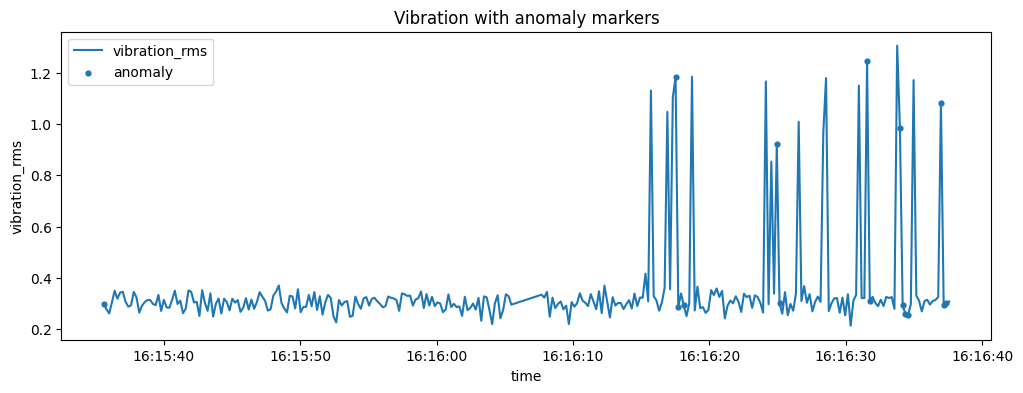

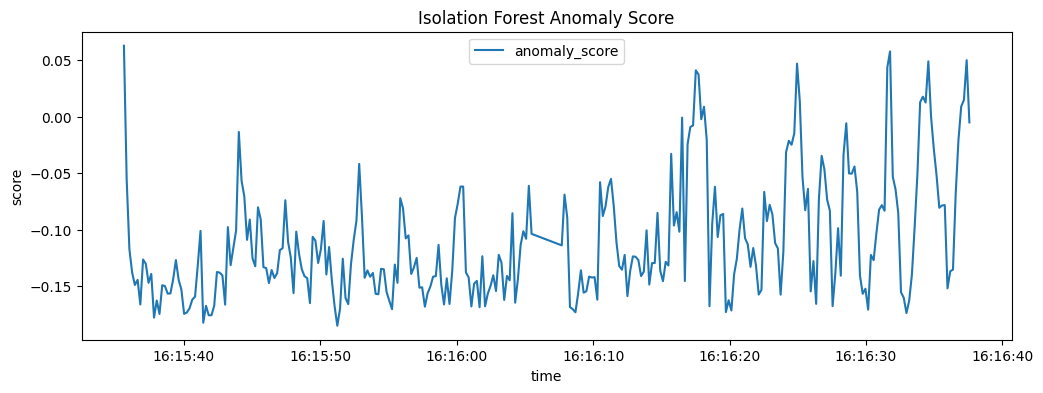

In [9]:

# 9) Plot telemetry & anomalies
import matplotlib.pyplot as plt
import numpy as np

ts = pd.to_datetime(df_sorted["ts"], unit="ms")
fig = plt.figure(figsize=(12,4))
plt.plot(ts, df_sorted["vibration_rms"], label="vibration_rms")
plt.scatter(ts[df_sorted["is_anomaly"]==1], df_sorted[df_sorted["is_anomaly"]==1]["vibration_rms"], s=12, label="anomaly")
plt.xlabel("time"); plt.ylabel("vibration_rms"); plt.title("Vibration with anomaly markers"); plt.legend(); plt.show()

fig = plt.figure(figsize=(12,4))
plt.plot(ts, df_sorted["anomaly_score"], label="anomaly_score")
plt.xlabel("time"); plt.ylabel("score"); plt.title("Isolation Forest Anomaly Score"); plt.legend(); plt.show()


In [10]:

# 10) Publish a twin-state snapshot back to MQTT (optional)
pub = mqtt.Client(client_id="colab_twin_pub")
pub.connect("localhost", 1883, 60)
snapshot = {
    "id": twin_state["id"],
    "health": twin_state["health"],
    "lastUpdated": twin_state["lastUpdated"],
    "latest": df_sorted.tail(1)[["temperature","pressure","vibration_rms","anomaly_score","is_anomaly"]].to_dict(orient="records")[0]
}
pub.publish(TOPIC_TWIN, json.dumps(snapshot))
pub.disconnect()
print("Twin snapshot published to:", TOPIC_TWIN)
print(snapshot)


Twin snapshot published to: site1/lineA/press01/twin
{'id': 'press01', 'health': 'ok', 'lastUpdated': '2025-09-22T16:16:37.578495Z', 'latest': {'temperature': 70.065, 'pressure': 100.606, 'vibration_rms': 0.3074, 'anomaly_score': -0.005160015247337668, 'is_anomaly': 0}}


/tmp/ipython-input-3120079669.py:2: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  pub = mqtt.Client(client_id="colab_twin_pub")


In [11]:

# 11) Send a command to the twin (e.g., set health warn/ok)
pub = mqtt.Client(client_id="colab_cmd_pub")
pub.connect("localhost", 1883, 60)
pub.publish(TOPIC_CMD, "set_health_warn")
time.sleep(0.5)
pub.publish(TOPIC_CMD, "set_health_ok")
pub.disconnect()
twin_state


/tmp/ipython-input-2907862250.py:2: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  pub = mqtt.Client(client_id="colab_cmd_pub")


{'id': 'press01',
 'type': 'Asset',
 'attributes': {'name': 'Hydraulic Press #1',
  'location': 'site1/lineA',
  'make': 'AcmeModel X'},
 'features': {'temperature': 70.065,
  'pressure': 100.606,
  'vibration_rms': 0.3074},
 'health': 'ok',
 'lastUpdated': '2025-09-22T16:16:37.578495Z'}


## (Optional) Cleanup
If you want to stop the broker, you can interrupt the runtime or kill the process:
```python
import os, signal
os.kill(broker.pid, signal.SIGTERM)
```
